In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters

In [3]:
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 185285 entries, 0 to 185284
Data columns (total 6 columns):
id_trip      185285 non-null int64
mode         74218 non-null object
purpose      74218 non-null object
starttime    185285 non-null object
endtime      185285 non-null object
geometry     185285 non-null object
dtypes: int64(1), object(5)
memory usage: 8.5+ MB
None


In [4]:
print(gdf.starttime.min(), gdf.starttime.max())

2017-09-18 04:16:58UTC 2017-10-18 03:50:08UTC


In [5]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,geometry
0,1547,None,None,2017-09-18 04:16:58UTC,2017-09-18 04:26:26UTC,"LINESTRING (-73.651166 45.544501, -73.65122700..."
1,308312,None,None,2017-09-18 06:17:46UTC,2017-09-18 06:58:49UTC,"LINESTRING (-73.650987 45.544496, -73.651011 4..."
2,384772,None,None,2017-09-18 09:30:24UTC,2017-09-18 10:17:28UTC,"(LINESTRING (-73.832869 45.636068, -73.831779 ..."
3,150744,Voiture / Moto,Reconduire / aller chercher une personne,2017-09-18 10:02:50UTC,2017-09-18 10:17:12UTC,"LINESTRING (-73.646385 45.54629, -73.646064999..."
4,199011,None,None,2017-09-18 10:18:40UTC,2017-09-18 10:27:44UTC,"(LINESTRING (-73.74549500000001 45.55839, -73...."


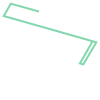

In [6]:
gdf.geometry[0]

In [29]:
# total of 70 unique travel modes
gdf['mode'].unique()

array([None, 'Voiture / Moto', 'À pied, Transport collectif',
       'Transport collectif', 'À pied', 'Vélo',
       'À pied, Transport collectif, Vélo',
       'Transport collectif, Voiture / Moto', 'À pied, Vélo',
       'À pied, Voiture / Moto, Vélo', 'Autopartage', 'Autre',
       'Transport collectif, Vélo',
       'À pied, Transport collectif, Voiture / Moto',
       'Transport collectif, Voiture / Moto, Vélo',
       'À pied, Voiture / Moto', 'Voiture / Moto, Vélo', 'Taxi', 'ND',
       'Taxi, Vélo', 'À pied, Autopartage, Vélo',
       'Autopartage, Transport collectif, Voiture / Moto',
       'Taxi, Voiture / Moto', 'À pied, Autopartage, Voiture / Moto',
       'Autopartage, Autre', 'À pied, Taxi, Vélo', 'Autopartage, Taxi',
       'Autopartage, Voiture / Moto',
       'Autopartage, Autre, Voiture / Moto',
       'Autopartage, Transport collectif',
       'À pied, Transport collectif, Voiture / Moto, Vélo',
       'Autre, Transport collectif', 'À pied, Autre, Transport collecti

In [35]:
gdf['mode'].str.split(',')

0                                   None
1                                   None
2                                   None
3                       [Voiture / Moto]
4                                   None
5                                   None
6                                   None
7                                   None
8                                   None
9                                   None
10                                  None
11                                  None
12                                  None
13                      [Voiture / Moto]
14                                  None
15        [À pied,  Transport collectif]
16                 [Transport collectif]
17                                  None
18                                  None
19                              [À pied]
20                      [Voiture / Moto]
21                      [Voiture / Moto]
22                 [Transport collectif]
23                                  None
24              